# Introducción

En el siguiente trabajo vamos a usar los datos etiquetados y no etiquetados para elaborar clasificadores semi y no supervisados.

Primero vamos a retomar lo que hicimos en el práctico combinado de Analisis y Visualización y Curación y vamos a armar dos grafos distintos con dos criterios distintos. Uno de usuarios según los retweets y otro con un criterio elegido por ustedes.

Luego vamos a correr un algoritmo para encontrar comunidades en esos grafos. Las comunidades nos van a permitir dividir el conjunto de entrenamiento en clusters.

Una vez que tenemos las comunidades/clusters definidos, debemos asignar cada uno a una clase. Cada elemento perteneciente a una comunidad asociada a una clase será etiquetado como de esa clase. Luego usaremos esos ejemplos para entrenar nuestro clasificador.

Vamos a hacer esto para los tres tópicos: aborto, cambio climático y feminismo.

In [35]:
import pandas as pd
# permite que una misma celda imprima varios resultados
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'
pd.set_option('display.max_rows', 20000)
pd.set_option('display.max_columns', 20000)
pd.set_option('display.max_colwidth', -1)
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import json

In [36]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [37]:
abortion = pd.read_csv('/content/drive/My Drive/Tweeter/Datasets/abortion_tweets.csv', engine='python')

In [38]:
print(len(abortion))
print(len(abortion["tweet.full_text"].unique()))

613550
95887


### Cobertura

In [39]:
print(len(abortion["tweet.full_text"]))
print(len(abortion["tweet.full_text"].dropna()))

613550
318860


Primera Cobertura

In [40]:
def get_text(tweet):
    if tweet["tweet.retweeted_status.text"] == tweet["tweet.retweeted_status.text"]:
        return tweet["tweet.retweeted_status.text"]
    else:
        return tweet["tweet.full_text"]

In [41]:
abortion["full_text"] = abortion.apply(get_text, axis=1)

In [42]:
print(len(abortion["tweet.full_text"]))
print(len(abortion["full_text"].dropna()))

613550
535492


In [43]:
#Veamos los tweets que aún nos aparecen como NaN en la columna full_text para ver a dónde podemos encontrar el texto de ese tweet:
abortion_filt1 = abortion[abortion['full_text'].isnull()]
abortion_filt1.head()

,_id,query,tweet.created_at,tweet.id_str,tweet.full_text,tweet.text,tweet.extended_tweet.full_text,tweet.display_text_range,tweet.entities,tweet.user.id_str,tweet.user.name,tweet.user.screen_name,tweet.user.location,tweet.user.verified,tweet.user.followers_count,tweet.user.friends_count,tweet.user.listed_count,tweet.user.favorites_count,tweet.user.statuses_count,tweet.user.created_at,tweet.user.following,tweet.retweet_status,tweet.retweeted_status.created_at,tweet.retweeted_status.id_str,tweet.retweeted_status.text,tweet.retweeted_status.user.id_str,tweet.retweeted_status.user.name,tweet.retweeted_status.user.screen_name,tweet.retweeted_status.user.location,tweet.retweeted_status.user.verified,tweet.retweeted_status.user.followers_count,tweet.retweeted_status.user.friends_count,tweet.retweeted_status.user.listed_count,tweet.retweeted_status.user.favorites_count,tweet.retweeted_status.user.statuses_count,tweet.retweeted_status.user.created_at,tweet.retweeted_status.user.id_str.1,tweet.retweeted_status.user.following,tweet.retweeted_status.retweet_status,tweet.retweeted_status.extended_tweet,full_text
208,ObjectId(5dc083fde36ea093ac65d2c3),streaming,Mon Nov 04 20:03:04 +0000 2019,1191445778847416321,NaN,@SpeakerPelosi Speaking of betraying your oath...all abortion supporters betray their as do all promoters of gun re… https://t.co/vpdz0NzJA0,@SpeakerPelosi Speaking of betraying your oath...all abortion supporters betray their as do all promoters of gun restrictions! Nancy's and all democrats have betrayed her oath for decades! You working for the people? Who believes this sh*t?! RT #forthepeople,"[15,140]","{""hashtags"":[],""urls"":[{""url"":""https://t.co/vpdz0NzJA0"",""expanded_url"":""https://twitter.com/i/web/status/1191445778847416321"",""display_url"":""twitter.com/i/web/status/1…"",""indices"":[117,140]}],""user_mentions"":[{""screen_name"":""SpeakerPelosi"",""name"":""Nancy Pelosi"",""id"":15764644,""id_str"":""15764644"",""indices"":[0,14]}],""symbols"":[]}",322376763,Guisseppi,guisseppi2,San Diego,False,55,362,3,NaN,7046,Thu Jun 23 02:30:38 +0000 2011,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
347,ObjectId(5dc08406e36ea093ac65d5f1),streaming,Mon Nov 04 20:03:12 +0000 2019,1191445814926643200,NaN,@Redlipsandquips Your forget transgender women with uteruses! What about if they need to get an abortion?? I hope y… https://t.co/9uskCQLu6w,@Redlipsandquips Your forget transgender women with uteruses! What about if they need to get an abortion?? I hope you support that. #homosexualsforautism,"[17,140]","{""hashtags"":[],""urls"":[{""url"":""https://t.co/9uskCQLu6w"",""expanded_url"":""https://twitter.com/i/web/status/1191445814926643200"",""display_url"":""twitter.com/i/web/status/1…"",""indices"":[117,140]}],""user_mentions"":[{""screen_name"":""Redlipsandquips"",""name"":""whore 4 gore"",""id"":{""$numberLong"":""1079796427285499905""},""id_str"":""1079796427285499905"",""indices"":[0,16]}],""symbols"":[]}",1191434909371387904,TheAutisticFeminist,TheAutisticFem,"Sunnyside, Calgary",False,0,0,0,NaN,12,Mon Nov 04 19:20:02 +0000 2019,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
350,ObjectId(5dc08408e36ea093ac65d65b),streaming,Mon Nov 04 20:03:15 +0000 2019,1191445825848664064,NaN,"yea, @jack and @TwitterSupport ?",NaN,NaN,"{""hashtags"":[],""urls"":[],""user_mentions"":[{""screen_name"":""jack"",""name"":""jack 🌍🌏🌎"",""id"":12,""id_str"":""12"",""indices"":[5,10]},{""screen_name"":""TwitterSupport"",""name"":""Twitter Support"",""id"":17874544,""id_str"":""17874544"",""indices"":[15,30]}],""symbols"":[]}",1022590100524294144,Shirley Diaz,Shirley47749323,NaN,False,2,40,0,NaN,47,Thu Jul 26 21:10:53 +0000 2018,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
373,ObjectId(5dc08423e36ea093ac65dd7f),streaming,Mon Nov 04 20:03:42 +0000 2019,1191445940147802112,NaN,@PPFA Time to shut down all federal government funding t

In [44]:
#Si bien hay muchos que tienen NaN en la columna tweet.extended_tweet.full_text, nos conviene primero combinar full_text con esta para que no nos queden los tweets cortados

Segunda Coberta

In [45]:
def get_text2(tweet):
    if tweet["tweet.extended_tweet.full_text"] == tweet["tweet.extended_tweet.full_text"]:  
        return tweet["tweet.extended_tweet.full_text"]
    else:
        return tweet["full_text"]

In [46]:
abortion["full_text2"] = abortion.apply(get_text2, axis=1)

In [47]:
print(len(abortion["tweet.full_text"]))
print(len(abortion["full_text2"].dropna()))

613550
578442


In [48]:
#Veamos de vuelta los tweets que aún no tienen el texto en full_text2
abortion_filt2 = abortion[abortion['full_text2'].isnull()]
abortion_filt2.head()

,_id,query,tweet.created_at,tweet.id_str,tweet.full_text,tweet.text,tweet.extended_tweet.full_text,tweet.display_text_range,tweet.entities,tweet.user.id_str,tweet.user.name,tweet.user.screen_name,tweet.user.location,tweet.user.verified,tweet.user.followers_count,tweet.user.friends_count,tweet.user.listed_count,tweet.user.favorites_count,tweet.user.statuses_count,tweet.user.created_at,tweet.user.following,tweet.retweet_status,tweet.retweeted_status.created_at,tweet.retweeted_status.id_str,tweet.retweeted_status.text,tweet.retweeted_status.user.id_str,tweet.retweeted_status.user.name,tweet.retweeted_status.user.screen_name,tweet.retweeted_status.user.location,tweet.retweeted_status.user.verified,tweet.retweeted_status.user.followers_count,tweet.retweeted_status.user.friends_count,tweet.retweeted_status.user.listed_count,tweet.retweeted_status.user.favorites_count,tweet.retweeted_status.user.statuses_count,tweet.retweeted_status.user.created_at,tweet.retweeted_status.user.id_str.1,tweet.retweeted_status.user.following,tweet.retweeted_status.retweet_status,tweet.retweeted_status.extended_tweet,full_text,full_text2
350,ObjectId(5dc08408e36ea093ac65d65b),streaming,Mon Nov 04 20:03:15 +0000 2019,1191445825848664064,NaN,"yea, @jack and @TwitterSupport ?",NaN,NaN,"{""hashtags"":[],""urls"":[],""user_mentions"":[{""screen_name"":""jack"",""name"":""jack 🌍🌏🌎"",""id"":12,""id_str"":""12"",""indices"":[5,10]},{""screen_name"":""TwitterSupport"",""name"":""Twitter Support"",""id"":17874544,""id_str"":""17874544"",""indices"":[15,30]}],""symbols"":[]}",1022590100524294144,Shirley Diaz,Shirley47749323,NaN,False,2,40,0,NaN,47,Thu Jul 26 21:10:53 +0000 2018,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
373,ObjectId(5dc08423e36ea093ac65dd7f),streaming,Mon Nov 04 20:03:42 +0000 2019,1191445940147802112,NaN,@PPFA Time to shut down all federal government funding to Planned Parenthood permanently.,NaN,"[6,89]","{""hashtags"":[],""urls"":[],""user_mentions"":[{""screen_name"":""PPFA"",""name"":""Planned Parenthood"",""id"":402957663,""id_str"":""402957663"",""indices"":[0,5]}],""symbols"":[]}",1176634669795872768,Arthur Childs,ArthurChilds10,NaN,False,35,7,0,NaN,3730,Tue Sep 24 23:09:14 +0000 2019,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
380,ObjectId(5dc08432e36ea093ac65dda7),streaming,Mon Nov 04 20:03:56 +0000 2019,1191445998008074240,NaN,Sexy Planned Parenthood near me,NaN,NaN,"{""hashtags"":[],""urls"":[],""user_mentions"":[],""symbols"":[]}",2798251111,sel,sleepylilsel,NaN,False,460,281,7,NaN,27785,Mon Sep 08 16:31:43 +0000 2014,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
381,ObjectId(5dc08433e36ea093ac65dda9),streaming,Mon Nov 04 20:03:57 +0000 2019,1191446003204804608,NaN,i saw this on a paper at the planned parenthood office lol,NaN,NaN,"{""hashtags"":[],""urls"":[],""user_mentions"":[],""symbols"":[]}",2768637555,toxic bitch,ayleaaann,la chingada,False,557,264,0,NaN,50363,Sat Sep 13 07:35:43 +0000 2014,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
382,ObjectId(5dc08434e36ea093ac65ddad),streaming,Mon Nov 04 20:03:59 +0000 2019,1191446009953566722,NaN,@okcupid I'll repeat until I'm blue in the face. Women have reproductive rights. They have the right to reproduce or not reproduce.,NaN,"[9,131]","{""hashtags"":[],""urls"":[],""user_mentions"":[{""screen_name"":""okcupid"",""name"":""OkCupid"",""id"":53543144,""id_str"":""53543144"",""indices"":[0,8]}],""symbols"":[]}",1165579850339573760,Matthew Vainauskas,MatthewVainaus3,NaN,False,527,580,1,NaN,10332,Sun Aug 25 11:01:50 +0000 2019,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Tercera Cobertura

In [49]:
abortion["full_text2"] = abortion["full_text2"].fillna(0)
abortion['category'] = np.where(abortion.full_text2 == 0 , 0, 1)
abortion['full_text2'] = np.where(abortion['category'] == 0, abortion['tweet.text'], abortion['full_text2'])

In [50]:
print(len(abortion["tweet.full_text"]))
print(len(abortion["full_text2"].dropna()))

613550
613550


## Grafo

#### De retweets

In [51]:
#Nos quedamos con los tweets que son retweets
retweets = abortion.dropna(subset=["tweet.retweeted_status.user.id_str"]) #Subset lo que hace es me elimina la fila si el nan está en la columna que le paso como parámetro
len(retweets["tweet.retweeted_status.user.id_str"])

462991

In [52]:
#Código para armar el grafo:
full_g = nx.Graph()
vertex_ids = set()


for user1, user2 in zip(retweets["tweet.user.id_str"], retweets["tweet.retweeted_status.user.id_str"]):
    full_g.add_edge(user1, user2)

In [53]:
#Estadística del grafo:
n = len(full_g.nodes)
m = len(full_g.edges)
complete = n * (n-1) / 2

print("Nodos: {:.0f}".format(n))
print("Ejes: {:.0f}".format(m))

Nodos: 235367
Ejes: 399417


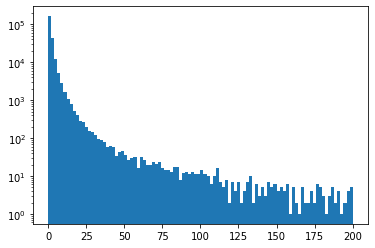

In [54]:
#Gráfico de nodos de acuerdo a su grado:
degrees = np.array([full_g.degree(node) for node in full_g.nodes()])

plt.hist(degrees, range=(0, 200), bins=100);
plt.semilogy();

In [55]:
#Recortamos el grafo para quedarnos con los nodos "influencers":
def subgraph_strong_nodes(g, n):
    """
    Devuelve subgrafo con nodos de grado mayor a n
    """
    good_nodes = [node for node in g.nodes() if g.degree(node) >= n]
    
    return g.subgraph(good_nodes)

In [56]:
g = subgraph_strong_nodes(full_g, 5)

print("Nos quedan {:.2f}M nodos (antes eran {:.2f}M)".format(
    len(g.nodes) / 1e6,
    len(full_g.nodes) / 1e6
))
print("Componentes conexas = {}".format(len(list(nx.connected_components(g)))))

Nos quedan 0.02M nodos (antes eran 0.24M)
Componentes conexas = 909


In [57]:
#Cantidad de usuarios en las componentes conexas
components = list(nx.connected_components(g))

print("Componentes conexas = {}".format(len(components)))

print("Componente 0  --> {:<6} usuarios".format(len(components[0])))

resto = [len(components[i]) for i in range(1, len(components))]
print("Restantes     --> {:<6} usuarios".format(sum(resto)))

Componentes conexas = 909
Componente 0  --> 18922  usuarios
Restantes     --> 983    usuarios


In [58]:
#Nos quedamos solo con la componente más significativa:
g = g.subgraph(components[0])

#### Alternativo

In [ ]:
g2 = # TODO

# Comunidades

Como método para detectar las comunidades vamos a usar el algoritmo de Louvain
https://es.wikipedia.org/wiki/M%C3%A9todo_de_Louvain

Louvain es un método iterativo que busca armar comunidades en función de maximizar la modularidad. A grandes rasgos, arma comunidades tales que hagan que la mayor cantidad de aristas conecten dos nodos que sean de la misma comunidad. El problema es que la solución ideal a esta modularidad es muy costosa computacionalmente. Por lo tanto, Louvain es una heurística iterativa (en cada iteración se acerca un poco más a una solución mejor sin necesariamente llegar a alcanzar una solución ideal). Al ser un método iterativo no es exacto: correrlo varias veces con los mismos parámetros puede dar distintos resultados. El algoritmo termina cuando logra estabilidad, es decir, un valor de modularidad que considera aceptable.

Nosotros vamos a trabajar con un parámetro específico de este algoritmo que es la resolución. La resolución afecta la estabilidad del sistema: a mayor resolución, se necesitan más iteraciones para lograr estabilidad. En particular, lo que a nosotros nos interesa, es que **a mayor resolución, el algoritmo encuentra menos comunidades de mayor tamaño** (se polariza).

Lo que nosotros queremos hacer es encontrar el menor valor de la resolución que nos de como resultado únicamente  dos comunidades polares que tengan más de una cierta cantidad de usuarios (definida en la variable users_threshold)

In [60]:
!pip install cylouvain

     |████████████████████████████████| 133kB 2.7MB/s 
  Created wheel for cylouvain: filename=cylouvain-0.2.2-cp36-cp36m-linux_x86_64.whl size=400431 sha256=5d7ec6830091eedff33f11d83ebd90335224872f2ba37f13d8cf1243ad3f7361
  Stored in directory: /root/.cache/pip/wheels/b9/db/5a/7af4abe124a9394aa70079289b6a2b3f5c8aeb709c0808bcf1
Successfully built cylouvain


In [96]:
# https://pypi.org/project/cylouvain/
import cylouvain
import time
from collections import Counter

# Devuelve todas las particiones según la resolución. Si hay una particion ideal
# (la menor particion que genere 2 o menos comunidades), la devuelve. Sino devuelve -1
def findPartitions(g, user_threshold, resolutions):
    resolutions.sort()
    best_resolution = -1
    found_best = False
    for resolution in resolutions:
        partitions = {}
        print("resolución {:.2f}".format(resolution), end="")

        partition = cylouvain.best_partition(g, resolution=resolution)

        num_partitions = len(set(partition.values()))
        counter = Counter(partition.values())

        # Aca le está diciendo que cuente cuantas son las que tienen usuarios mayores al threshold
        important_partitions = len([_ for x in counter.items() if x[1] > user_threshold])


        if important_partitions <= 2 and not found_best:
            best_resolution = resolution
            found_best = True
            
        print("---> {} particiones ({} con más de {} usuarios)".format(
            num_partitions,
            important_partitions,
            user_threshold,
        ))
        #print("Tiempo: {:.2f} minutos".format((end - begin) / 60))
        partitions[resolution] = partition
    #agrego al return el parámetro partition, ya que se usa en la siguiente función 
    return partition, partitions, best_resolution

In [97]:
# Ejemplo
partition, partitions, resolution = findPartitions(g, 100,  [1.0, 1.5, 2.0, 3.0, 5.0, 6.0, 7.0, 10.0, 15.0])

resolución 1.00---> 29 particiones (9 con más de 100 usuarios)
resolución 1.50---> 12 particiones (8 con más de 100 usuarios)
resolución 2.00---> 11 particiones (7 con más de 100 usuarios)
resolución 3.00---> 6 particiones (5 con más de 100 usuarios)
resolución 5.00---> 5 particiones (4 con más de 100 usuarios)
resolución 6.00---> 5 particiones (4 con más de 100 usuarios)
resolución 7.00---> 5 particiones (4 con más de 100 usuarios)
resolución 10.00---> 3 particiones (3 con más de 100 usuarios)
resolución 15.00---> 3 particiones (3 con más de 100 usuarios)


In [98]:
# Aca paso del formato lista de tupla<nodo, Número de comunidad> a un mapa que para cada comunidad tiene la lista de los nodos que pertenecen
if resolution != -1:
    #partition = partitions[resolution] #lo borre porque partition no existe
    partition_to_ids = {partition_number:[] for partition_number in range(len(set(partition.values())))}

    num_partitions = len(set(partition.values()))
    for user_id, user_partition in partition.items():
        partition_to_ids[user_partition].append(user_id)
else:
    print("Hay más de dos particiones principales")
    

Hay más de dos particiones principales


### Ejercicio 1

Prueben distintos valores de user_threshold y distintas resoluciones evaluando cosas como cuantos (y cuales) nodos del grafo (sean los nodos usuarios u otra cosa) les quedan por fuera de las dos comunidades más grandes (no necesariamente es malo que queden muchos nodos afuera si verdaderamente no tienen una postura clara sobre el tópico); que proporcion tienen esas dos comunidades más grandes: ¿son parejas entre sí o no?; en el caso de que los nodos sean usuarios, además de los usuarios, ¿son parejas la cantidad de tweets que postean esos usuarios? ¿Cuántos tweets hay de cada comunidad?

In [99]:
partition, partitions, resolution = findPartitions(g, 500,  [1.0, 1.5, 2.0, 3.0, 5.0, 6.0, 7.0, 10.0, 15.0])

resolución 1.00---> 29 particiones (5 con más de 500 usuarios)
resolución 1.50---> 12 particiones (5 con más de 500 usuarios)
resolución 2.00---> 11 particiones (4 con más de 500 usuarios)
resolución 3.00---> 6 particiones (3 con más de 500 usuarios)
resolución 5.00---> 5 particiones (2 con más de 500 usuarios)
resolución 6.00---> 5 particiones (2 con más de 500 usuarios)
resolución 7.00---> 5 particiones (2 con más de 500 usuarios)
resolución 10.00---> 3 particiones (2 con más de 500 usuarios)
resolución 15.00---> 3 particiones (2 con más de 500 usuarios)


In [100]:
# Aca paso del formato lista de tupla<nodo, Número de comunidad> a un mapa que para cada comunidad tiene la lista de los nodos que pertenecen
if resolution != -1:
    partition_to_ids = {partition_number:[] for partition_number in range(len(set(partition.values())))}

    num_partitions = len(set(partition.values()))
    for user_id, user_partition in partition.items():
        partition_to_ids[user_partition].append(user_id)
else:
    print("Hay más de dos particiones principales")

In [109]:
comunidad_1 = partition_to_ids[0]
comunidad_2 = partition_to_ids[1]
comunidad_3 = partition_to_ids[2]

In [110]:
tweet_comunidad_1 = retweets[retweets['tweet.user.id_str'].isin(comunidad_1)]
tweet_comunidad_2 = retweets[retweets['tweet.user.id_str'].isin(comunidad_2)]
tweet_comunidad_3 = retweets[retweets['tweet.user.id_str'].isin(comunidad_3)]

In [120]:
any(item in comunidad_1 for item in comunidad_2)

False

In [121]:
any(item in comunidad_1 for item in comunidad_3)

False

In [122]:
any(item in comunidad_2 for item in comunidad_3)

False

In [131]:
print('comunidad 1: ' + str(len(comunidad_1)))
print('comunidad 2: ' + str(len(comunidad_2)))
print('comunidad 3: ' + str(len(comunidad_3)))
print('total users comunidades: ' + str(len(comunidad_1) + len(comunidad_2) + len(comunidad_3)))
print('total users component 0: ' + str(len(components[0])))

comunidad 1: 13163
comunidad 2: 126
comunidad 3: 5633
total users comunidades: 18922
total users component 0: 18922


### Ejercicio 2

Armen un script que para cada comunidad muestre datos que permitan evaluar cuan bien se ajusta a la clase a la que la queremos asignar. Algunos ejemplos pueden ser: usuarios con más cantidad de retweets, tweets más retwiteados, tweets de los usuarios con más cantidad de tweets, etc. Tiene que ser algo que de un panorama de qué es esa comunidad pero a su vez sencillo de ver y que convenza a alguien que lo ve desde afuera que usar esas comunidades puede servir.

### Ejercicio 3

Hagan una nube de palabras con los tweets de cada comunidad y analicen cuan fácil o difícil es inferir la clase de esa comunidad mirando la nube.

### Ejercicio 4

Decidan una clase para cada comunidad. Justifiquen su decisión planteando cuán ajustada les parece que es la asignación en función de los ejercicios anteriores

### Ejercicio 5

Hacer los ejercicios anteriores para los tres tópicos y comparar los resultados entre sí: ¿hay tópicos para los cuales las comunidades reflejan mejor o peor la polaridad respecto al posicionamiento? ¿Por qué les parece que esto sucede así?

### Ejercicio 6

Generar un dataset con todos los tweets asociados a cada comunidad, cada uno etiquetado según la comunidad a la que pertenece. Usar esos datasets como entrenamiento de algun clasificador basado en alguno de los tres algoritmos que vieron en el práctico pasado: SVM's, Random Forests o Red Neuronal. Reportar las mismas métricas (Accuracy, F1 micro, macro y average)

### Ejercicio 7

Para uno de los tres tópicos, exploren un enfoque mixto supervisado/semi-supervisado. El enfoque mixto puede ser: o bien un Voting Classifier con dos clasificadores que usen el corpus supervisado y uno basado en comunidades (o uno y dos, como prefieran), o un clasificador entrenado con una mitad de ejemplos tomados del corpus de tweets etiquetados y la otra mitad de comunidades. La idea es que definan ustedes alguna manera de usar todos los datos: los etiquetados y los no etiquetados. Luego comparen los resultados obtenidos con las versiones puramente supervisadas o puramente basadas en comunidades.